# Anticipez les besoins en consommations de bâtiments

## Étape 5 : Optimisez et interprétez le modèle

### Reprendre les éléments de notre notebook de l'étape 4

* J'importe les librairies nécessaires

In [1]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate, 
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
building_cv = pd.read_csv("../Data/Projet_3_etape3_clean.csv")

* Petit récapitulatif

In [2]:
data_avant_transformation = building_cv.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')

Nous retrouvons 1601 lignes et nous avons 48 colonnes avant le nettoyage des données avant transformation.


### Recommendation 1 : Utiliser la méthode GridSearchCV importée plus haut dans le Notebook et regarder la documentation de scikit-learn sur cette méthode afin de bien l'adapter à votre usage.

#### Afin d'utiliser la fonction GridSearchCV sur le modèle, on va le faire étape par étape

#### Nous devons tester la validation croisée sur notre meilleur modèle. A l'étape précédente nous avons vu que c'était celui de LinearRegression. (Nous testerons le deuxième meilleur modèle par la suite)

* J'enregistre mes colonnes

In [3]:
numerical_cols = [
    'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking',
    'NbSourcesEnergies','SecondUseRatio',
    'ThirdUseRatio','AreaPerFloor']

encoded_cols = [
    'HasSteam','HasElectricity','HasGas','PrimaryPropertyType_Distribution_Center','PrimaryPropertyType_Hospital',
    'PrimaryPropertyType_Hotel','PrimaryPropertyType_K_12_School','PrimaryPropertyType_Laboratory','PrimaryPropertyType_Large_Office',
    'PrimaryPropertyType_Medical_Office','PrimaryPropertyType_Mixed_Use_Property','PrimaryPropertyType_Office','PrimaryPropertyType_Other',
    'PrimaryPropertyType_Refrigerated_Warehouse','PrimaryPropertyType_Residence_Hall','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail_Store',
    'PrimaryPropertyType_Self_Storage_Facility','PrimaryPropertyType_Senior_Care_Community','PrimaryPropertyType_Small_and_Mid_Sized_Office',
    'PrimaryPropertyType_Supermarket_Grocery_Store','PrimaryPropertyType_University','PrimaryPropertyType_Warehouse','PrimaryPropertyType_Worship_Facility',
    'Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER_DUWAMISH',
    'Neighborhood_LAKE_UNION','Neighborhood_MAGNOLIA_QUEENANNE','Neighborhood_NORTH','Neighborhood_NORTHEAST','Neighborhood_NORTHWEST','Neighborhood_SOUTHEAST',
    'Neighborhood_SOUTHWEST','UsageType_Bin','AgeGroup'
]

* Je sépare X et y (target déjà en log)


In [4]:
y = building_cv["SiteEnergyUse(kBtu)"]
X = building_cv.drop(columns=["SiteEnergyUse(kBtu)"])

* Je split mon jeu en apprentissage et en test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

* Je standardise ma liste numerical_cols et je laisse intact celle déjà encodée

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', 'passthrough', encoded_cols)
    ])

* J'ajoute la fonction Pipeline pour faire indiquer le modèle que je veux lancer en ajoutant mon DataFrame reconstitué. En scikit-learn, une pipeline est un objet qui enchaîne plusieurs étapes de traitement et un modèle en un seul bloc. Elle sert à automatiser le workflow de machine learning et à éviter de refaire les transformations à la main à chaque fois.

In [7]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

* J'indique mes hyperparamètres

In [8]:
param_grid = {
    "model__fit_intercept": [True, False],
    "model__positive": [True, False]
    
}

* Je remplis la fonction GridSearchCV

In [9]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error', # Le  scoring définit la métrique utilisée pour évaluer les modèles à chaque fold. On peut en mettre qu'un
    n_jobs=-1, # Le nombre de processeurs à utiliser pour exécuter le GridSearchCV. Ici c'est tout les CPU
    verbose=2 # Contrôle le niveau d’affichage des informations pendant l’exécution
)

* J'entraîne le modèle

In [10]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....model__fit_intercept=True, model__positive=True; total time=   0.0s
[CV] END ....model__fit_intercept=True, model__positive=True; total time=   0.0s
[CV] END ....model__fit_intercept=True, model__positive=True; total time=   0.0s
[CV] END ....model__fit_intercept=True, model__positive=True; total time=   0.0s
[CV] END ...model__fit_intercept=True, model__positive=False; total time=   0.0s
[CV] END ...model__fit_intercept=True, model__positive=False; total time=   0.0s
[CV] END ...model__fit_intercept=True, model__positive=False; total time=   0.0s
[CV] END ....model__fit_intercept=True, model__positive=True; total time=   0.0s
[CV] END ...model__fit_intercept=True, model__positive=False; total time=   0.0s
[CV] END ...model__fit_intercept=True, model__positive=False; total time=   0.0s
[CV] END ...model__fit_intercept=False, model__positive=True; total time=   0.0s
[CV] END ...model__fit_intercept=False, model__po

,estimator,Pipeline(step...egression())])
,param_grid,"{'model__fit_intercept': [True, False], 'model__positive': [True, False]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


* J'enregistre quel est le meilleur modèle, je réalise la prédiction et j'évalue

In [11]:
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur RMSE :", -grid_search.best_score_)

Meilleurs paramètres : {'model__fit_intercept': True, 'model__positive': True}
Meilleur RMSE : 8050231.163964661


#### Maintenant que nous avons trouvé les meilleurs paramètres de notre modèle, nous pouvons l'appliquer à notre cross validate de l'étape 4, afin de réaliser une comparaison.

In [12]:
# J'enregsitre mes colonnes
numerical_cols = [
    'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking',
    'NbSourcesEnergies','SecondUseRatio',
    'ThirdUseRatio','AreaPerFloor']

encoded_cols = [
    'HasSteam','HasElectricity','HasGas','PrimaryPropertyType_Distribution_Center','PrimaryPropertyType_Hospital',
    'PrimaryPropertyType_Hotel','PrimaryPropertyType_K_12_School','PrimaryPropertyType_Laboratory','PrimaryPropertyType_Large_Office',
    'PrimaryPropertyType_Medical_Office','PrimaryPropertyType_Mixed_Use_Property','PrimaryPropertyType_Office','PrimaryPropertyType_Other',
    'PrimaryPropertyType_Refrigerated_Warehouse','PrimaryPropertyType_Residence_Hall','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail_Store',
    'PrimaryPropertyType_Self_Storage_Facility','PrimaryPropertyType_Senior_Care_Community','PrimaryPropertyType_Small_and_Mid_Sized_Office',
    'PrimaryPropertyType_Supermarket_Grocery_Store','PrimaryPropertyType_University','PrimaryPropertyType_Warehouse','PrimaryPropertyType_Worship_Facility',
    'Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER_DUWAMISH',
    'Neighborhood_LAKE_UNION','Neighborhood_MAGNOLIA_QUEENANNE','Neighborhood_NORTH','Neighborhood_NORTHEAST','Neighborhood_NORTHWEST','Neighborhood_SOUTHEAST',
    'Neighborhood_SOUTHWEST','UsageType_Bin','AgeGroup'
    ]

# Je sépare X et y
y = building_cv["SiteEnergyUse(kBtu)"]
X = building_cv.drop(columns=["SiteEnergyUse(kBtu)"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# On applique StandardScaler seulement aux colonnes numériques
# On laisse passer les colonnes encodées sans modification (pas besoin de scaler)
# Utilisation de ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', 'passthrough', encoded_cols)
    ])
# Je split mon jeu en apprentissage et en test
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression(
        fit_intercept=True,   # hyperparamètre choisi
        positive=True
        ))
])

# Définition de nos indicateurs
def rmse_original(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae_original(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape_original(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def r2_original(y_true, y_pred):
    return r2_score(y_true, y_pred)
scoring = {
    'RMSE': make_scorer(rmse_original, greater_is_better=False),
    'MAE': make_scorer(mae_original, greater_is_better=False),
    'MAPE': make_scorer(mape_original, greater_is_better=False),
    'R2': make_scorer(r2_original, greater_is_better=True),

}

# Cross-validation pour le modèle
results_all = []

cv_results = cross_validate(
    pipeline,
    X,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Stockage des résultats pour LinearRegression
results_all.append({
     "Modèle": "LinearRegression",
     "RMSE": f"{-cv_results['test_RMSE'].mean():.2f} ± {cv_results['test_RMSE'].std():.2f}",
     "MAE": f"{-cv_results['test_MAE'].mean():.2f} ± {cv_results['test_MAE'].std():.2f}",
     "MAPE (%)": f"{-cv_results['test_MAPE'].mean()*100:.2f} ± {cv_results['test_MAPE'].std()*100:.2f}",
     "R2": f"{cv_results['test_R2'].mean():.4f} ± {cv_results['test_R2'].std():.2f}"
})

df_results = pd.DataFrame(results_all)
print(df_results)

             Modèle                     RMSE                      MAE  \
0  LinearRegression  7224372.03 ± 2909354.57  3664032.90 ± 1388442.07   

         MAPE (%)             R2  
0  134.71 ± 49.31  0.6405 ± 0.10  


Comparaison avec et sans optimisation des hyperparamètres du modèle LinearRegression :

Métrique : ancien modèle vs optimisé
* RMSE : 7.213M ± 2.799M vs 7.224M ± 2.909M
* MAE : 3.683M ± 1.273M vs 3.664M ± 1.388M
* MAPE : 142.94% ± 55.18 vs 134.71% ± 49.31
* R2 : 0.6398 ± 0.09 vs 0.6405 ± 0.10

Interprétation des résultats vs le modèle à l'étape 4 sans optimisation des hyperparamètres
* Amélioration du score MAE & MAPE en baissant de 143% à 135%.
* Légère augmentation du R2 en passant de 63,98% à 64,05%
* L’optimisation des hyperparamètres a apporté un peu d'amélioration à notre modèle, tout en se rappelant que le modèle de Regression Linéaire ne dispose de beaucoup d'hyperparamètres

Conclusion :
* L'amélioration du MAPE suggère une meilleure gestion des erreurs relatives, mais globalement les performances sont stables.

#### Ajout de la permutation importance ici car je test le deuxième meilleur modèle juste après.

### Recommendation 2 : Il est coutume de représenter la feature importance sous forme d’un histogramme.

#### Feature importance : Création d'un tableau récapitulatif

* La Feature Importance consiste à estimer de manière objective l’utilité d’une caractéristique. Cette démarche peut s’avérer utile pour sélectionner les caractéristiques.

#### Utilisation de la permutation importance pour le modèle de Regréssion Linéaire

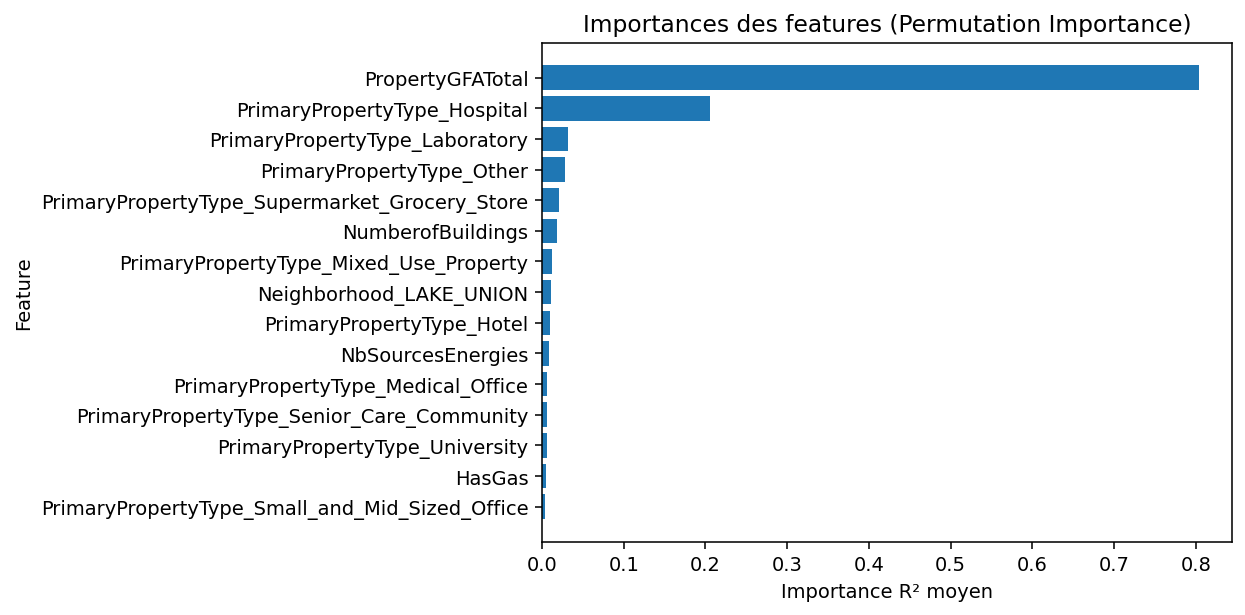


=== Permutation importance — Top 15 ===
                                       feature  importance_mean  importance_std
                              PropertyGFATotal         0.804180        0.022556
                  PrimaryPropertyType_Hospital         0.205772        0.007997
                PrimaryPropertyType_Laboratory         0.031661        0.003641
                     PrimaryPropertyType_Other         0.027789        0.002370
 PrimaryPropertyType_Supermarket_Grocery_Store         0.021359        0.002562
                             NumberofBuildings         0.018004        0.003082
        PrimaryPropertyType_Mixed_Use_Property         0.012059        0.002243
                       Neighborhood_LAKE_UNION         0.010465        0.001143
                     PrimaryPropertyType_Hotel         0.010333        0.001736
                             NbSourcesEnergies         0.009090        0.001762
            PrimaryPropertyType_Medical_Office         0.006007        0.001489

In [13]:
from sklearn.inspection import permutation_importance

pipeline.fit(X, y)

perm = permutation_importance(
    estimator=pipeline,
    X=X,
    y=y,
    scoring='r2',# ou 'neg_root_mean_squared_error'
    n_repeats=10,                
    random_state=42,
    n_jobs=-1
)

# DataFrame des importances
feature_names = numerical_cols + encoded_cols 
perm_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm.importances_mean,
        'importance_std': perm.importances_std
    })
    .sort_values('importance_mean', ascending=False)
)

# Top 15 pour lisibilité
topk = 15
top_df = perm_df.head(topk).iloc[::-1] 

# Graphique
plt.figure(figsize=(9, 4.5), dpi=140)
plt.barh(top_df['feature'], top_df['importance_mean'])
plt.title("Importances des features (Permutation Importance)")
plt.xlabel("Importance R² moyen") 
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Afficher le tableau Top 15
print("\n=== Permutation importance — Top 15 ===")
print(top_df.iloc[::-1].to_string(index=False)) 

* Dominance de PropertyGFATotal.
* Importance de certains types de bâtiments qui expliquent une partie du modèle.
* Dans le top 15 on ne retrouve pas de notion de Quartier.
* On peut noter que l'on retrouve quelques ratios que nous avons créé qui se retrouvent dans les plus utiles comme HasGas etNbSourcesEnergies

#### Test sur le deuxième meilleur modèle : RandomForestRegressor

##### Application du GridSearchCV

In [16]:
numerical_cols = [
    'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking',
    'NbSourcesEnergies','SecondUseRatio',
    'ThirdUseRatio','AreaPerFloor']

encoded_cols = [
    'HasSteam','HasElectricity','HasGas','PrimaryPropertyType_Distribution_Center','PrimaryPropertyType_Hospital',
    'PrimaryPropertyType_Hotel','PrimaryPropertyType_K_12_School','PrimaryPropertyType_Laboratory','PrimaryPropertyType_Large_Office',
    'PrimaryPropertyType_Medical_Office','PrimaryPropertyType_Mixed_Use_Property','PrimaryPropertyType_Office','PrimaryPropertyType_Other',
    'PrimaryPropertyType_Refrigerated_Warehouse','PrimaryPropertyType_Residence_Hall','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail_Store',
    'PrimaryPropertyType_Self_Storage_Facility','PrimaryPropertyType_Senior_Care_Community','PrimaryPropertyType_Small_and_Mid_Sized_Office',
    'PrimaryPropertyType_Supermarket_Grocery_Store','PrimaryPropertyType_University','PrimaryPropertyType_Warehouse','PrimaryPropertyType_Worship_Facility',
    'Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER_DUWAMISH',
    'Neighborhood_LAKE_UNION','Neighborhood_MAGNOLIA_QUEENANNE','Neighborhood_NORTH','Neighborhood_NORTHEAST','Neighborhood_NORTHWEST','Neighborhood_SOUTHEAST',
    'Neighborhood_SOUTHWEST','UsageType_Bin','AgeGroup'
]
# Je sépare X et y (target déjà en log)
y = building_cv["SiteEnergyUse(kBtu)"]
X = building_cv.drop(columns=["SiteEnergyUse(kBtu)"])
# Je split mon jeu en apprentissage et en test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Je standardise ma liste numerical_cols et je laisse intact celle déjà encodée
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', 'passthrough', encoded_cols)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
    ])
# J'indique mes hyperparamètres
param_grid = {
    'model__n_estimators': [50, 100], # Le nombre d’arbres dans la forêt aléatoire
    'model__max_depth': [None, 10, 20], # La profondeur maximale des arbres
    'model__min_samples_leaf': [1, 2, 4] # Le nombre minimum d’échantillons dans une feuille
    
}
# Je remplis la fonction GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error', # Le  scoring définit la métrique utilisée pour évaluer les modèles à chaque fold. On peut en mettre qu'un
    n_jobs=-1, # Le nombre de processeurs à utiliser pour exécuter le GridSearchCV. Ici c'est tout les CPU
    verbose=2 # Contrôle le niveau d’affichage des informations pendant l’exécution
)
# J'entraîne le modèle
grid_search.fit(X_train, y_train)
# J'enregistre quel est le meilleur modèle, je réalise la prédiction et j'évalue
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur RMSE :", -grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   1.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=50; total time=   0.9s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=100; total time=   1.7s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__n_estimators=50; total time=   0.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=100; total time=   1.7s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__n_estimators=100; total time=   1.8s
[CV] END model__ma

##### Application du cross validate

In [18]:
# J'enregsitre mes colonnes
numerical_cols = [
    'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking',
    'NbSourcesEnergies','SecondUseRatio',
    'ThirdUseRatio','AreaPerFloor']

encoded_cols = [
    'HasSteam','HasElectricity','HasGas','PrimaryPropertyType_Distribution_Center','PrimaryPropertyType_Hospital',
    'PrimaryPropertyType_Hotel','PrimaryPropertyType_K_12_School','PrimaryPropertyType_Laboratory','PrimaryPropertyType_Large_Office',
    'PrimaryPropertyType_Medical_Office','PrimaryPropertyType_Mixed_Use_Property','PrimaryPropertyType_Office','PrimaryPropertyType_Other',
    'PrimaryPropertyType_Refrigerated_Warehouse','PrimaryPropertyType_Residence_Hall','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail_Store',
    'PrimaryPropertyType_Self_Storage_Facility','PrimaryPropertyType_Senior_Care_Community','PrimaryPropertyType_Small_and_Mid_Sized_Office',
    'PrimaryPropertyType_Supermarket_Grocery_Store','PrimaryPropertyType_University','PrimaryPropertyType_Warehouse','PrimaryPropertyType_Worship_Facility',
    'Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER_DUWAMISH',
    'Neighborhood_LAKE_UNION','Neighborhood_MAGNOLIA_QUEENANNE','Neighborhood_NORTH','Neighborhood_NORTHEAST','Neighborhood_NORTHWEST','Neighborhood_SOUTHEAST',
    'Neighborhood_SOUTHWEST','UsageType_Bin','AgeGroup'
    ]

# Je sépare X et y (target déjà en log)
y = building_cv["SiteEnergyUse(kBtu)"]
X = building_cv.drop(columns=["SiteEnergyUse(kBtu)"])


# On applique StandardScaler seulement aux colonnes numériques
# On laisse passer les colonnes encodées sans modification (pas besoin de scaler)
# Utilisation de ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', 'passthrough', encoded_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        random_state=42, max_depth=20,
        min_samples_leaf=1, n_estimators=50
        ))
])

# Indicateurs de performances
def rmse_original(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae_original(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape_original(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def r2_original(y_true, y_pred):
    return r2_score(y_true, y_pred)
scoring = {
    'RMSE': make_scorer(rmse_original, greater_is_better=False),
    'MAE': make_scorer(mae_original, greater_is_better=False),
    'MAPE': make_scorer(mape_original, greater_is_better=False),
    'R2': make_scorer(r2_original, greater_is_better=True),

}


# Cross-validation pour le modèle
results_all = []

cv_results = cross_validate(
    pipeline,
    X,
    y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Stockage des résultats pour RandomForest
results_all.append({
     "Modèle": "RandomForest",
     "RMSE": f"{-cv_results['test_RMSE'].mean():.2f} ± {cv_results['test_RMSE'].std():.2f}",
     "MAE": f"{-cv_results['test_MAE'].mean():.2f} ± {cv_results['test_MAE'].std():.2f}",
     "MAPE (%)": f"{-cv_results['test_MAPE'].mean()*100:.2f} ± {cv_results['test_MAPE'].std()*100:.2f}",
     "R2": f"{cv_results['test_R2'].mean():.4f} ± {cv_results['test_R2'].std():.2f}"
})

df_results = pd.DataFrame(results_all)
print(df_results)

         Modèle                     RMSE                      MAE  \
0  RandomForest  7398934.81 ± 3344859.55  3398231.56 ± 1815432.99   

        MAPE (%)             R2  
0  88.21 ± 12.48  0.6140 ± 0.18  


Comparaison avec et sans optimisation des hyperparamètres du modèle de RandomForestRegressor :

Métrique : ancien modèle vs optimisé
* RMSE : 7.454M ± 3.163M vs 7.399M ± 3.345M
* MAE : 3.381M ± 1.777M vs 3.398M ± 1.815M
* MAPE : 87.33% ± 12.32 vs 88.21% ± 12.48
* R2 : 0.6085 ± 0.16 vs 0.6140 ± 0.18

Interprétation des résultats vs le modèle à l’étape 4 (sans optimisation des hyperparamètres)
* RMSE : légère amélioration → l’erreur quadratique moyenne baisse un peu.
* MAE & MAPE : très proches, voire légèrement moins bons après optimisation → pas d’amélioration réelle.
* R2 : légère hausse (60.9% → 61.4%) → le modèle explique un peu mieux la variance.